In [1]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os

from scipy.ndimage import gaussian_filter

#PW
import torchvision.transforms as T
from PIL import Image
from matplotlib import cm

In [2]:
# train clean images
train_csv = pd.read_csv('mnist_train.csv')
train = train_csv.iloc[:,1:]
train = train.values / 255.
train = np.reshape(train, (-1, 1, 28, 28))
np.save('../data/np/train/raw.npy', train)

In [3]:
# train labels
labels_train = np.zeros_like(train)
labels_train[train >= 0.5] = 1
labels_train[train < 0.5] = 0
np.save('../data/np/train/labels.npy', labels_train)

In [4]:
# train gaussian images
noise = np.random.normal(0, 0.2, train.shape)
mask_overflow_upper = train + noise >= 1.0
mask_overflow_lower = train + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_gaussian2 = train + noise
np.save('../data/np/train/gaussian2.npy', images_gaussian2)

In [5]:
# test clean images
test_csv = pd.read_csv('mnist_test.csv')
test = test_csv.iloc[:,1:]
test = test.values / 255.
test = np.reshape(test, (-1, 1, 28, 28))
np.save('../data/np/test/raw.npy', test)

In [6]:
# test labels
labels_test = np.zeros_like(test)
labels_test[test >= 0.5] = 1
labels_test[test < 0.5] = 0
np.save('../data/np/test/labels.npy', labels_test)

In [7]:
# test gaussian images
noise = np.random.normal(0, 1, test.shape)
mask_overflow_upper = test + noise >= 1.0
mask_overflow_lower = test + noise < 0.0
noise[mask_overflow_upper] = 1.0
noise[mask_overflow_lower] = 0.0
images_gaussian10 = test + noise
np.save('../data/np/test/gaussian10.npy', images_gaussian10)

In [8]:
blurred = gaussian_filter(train, sigma=(0,0,0.5,0.5))

In [9]:
test.shape

(10000, 1, 28, 28)

In [10]:
train.shape

(60000, 1, 28, 28)

In [12]:
#blurrer = T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
#train_torch = torch.from_numpy(train.values)
#train_pil = Image.fromarray(np.uint8(cm.gist_earth(np.array(train)*255)))
#train_blur = [blurrer(train_pil) for _ in range(4)]

In [13]:
def display(rows, columns, images, values=[], predictions=[]):
    fig = plt.figure(figsize=(9, 11))
    ax = []
    for i in range(columns*rows):
        img = images[i,0,:,:]
        ax.append(fig.add_subplot(rows, columns, i+1))
        title = ""
        if(len(values) == 0):
            title = "Pred:" + str(predictions[i])
        elif(len(predictions) == 0):
            title = "Value:" + str(values[i])
        elif(len(values) != 0 and len(predictions) != 0):
            title = "Value:" + str(values[i]) + "\nPred:" + str(predictions[i])
        ax[-1].set_title(title)  # set title
        plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    plt.show()

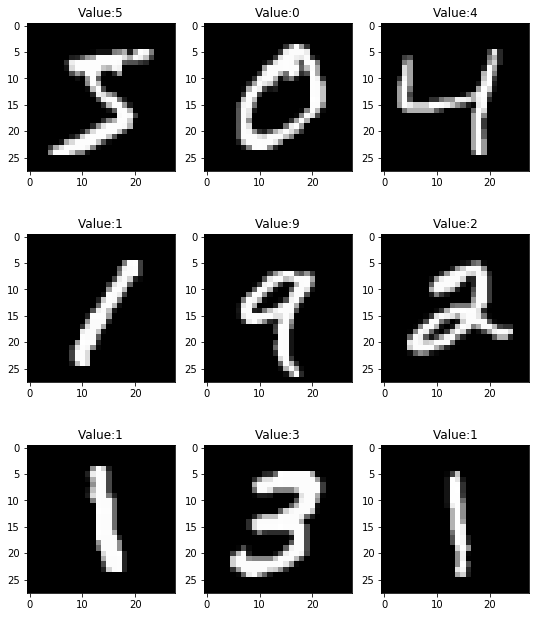

In [14]:
display(rows=3, columns=3, images=train, values=train_csv.iloc[:,0], predictions=[])

In [15]:
def remove(digit, x, y):
    idx = (y != digit).nonzero()
    return idx

In [16]:
#train_no3, labels_train_no3 = remove(3, train, labels_train)
n_cut = 4
idx_cut = remove(n_cut, train, train_csv.iloc[:,0].values)
train_cut = train[idx_cut]
labels_train_cut = labels_train[idx_cut]

In [17]:
train_cut = np.reshape(train_cut, (-1, 1, 28, 28))
train_cut.shape

(54158, 1, 28, 28)

In [18]:
labels_train_cut.shape

(54158, 1, 28, 28)

In [19]:
np.save('../data/np/train/images_cut.npy', train_cut)
np.save('../data/np/train/labels_cut.npy', labels_train_cut)
#np.save('../data/np/test/images_cut.npy', test_cut)
#np.save('../data/np/test/labels_cut.npy', labels_test_cut)

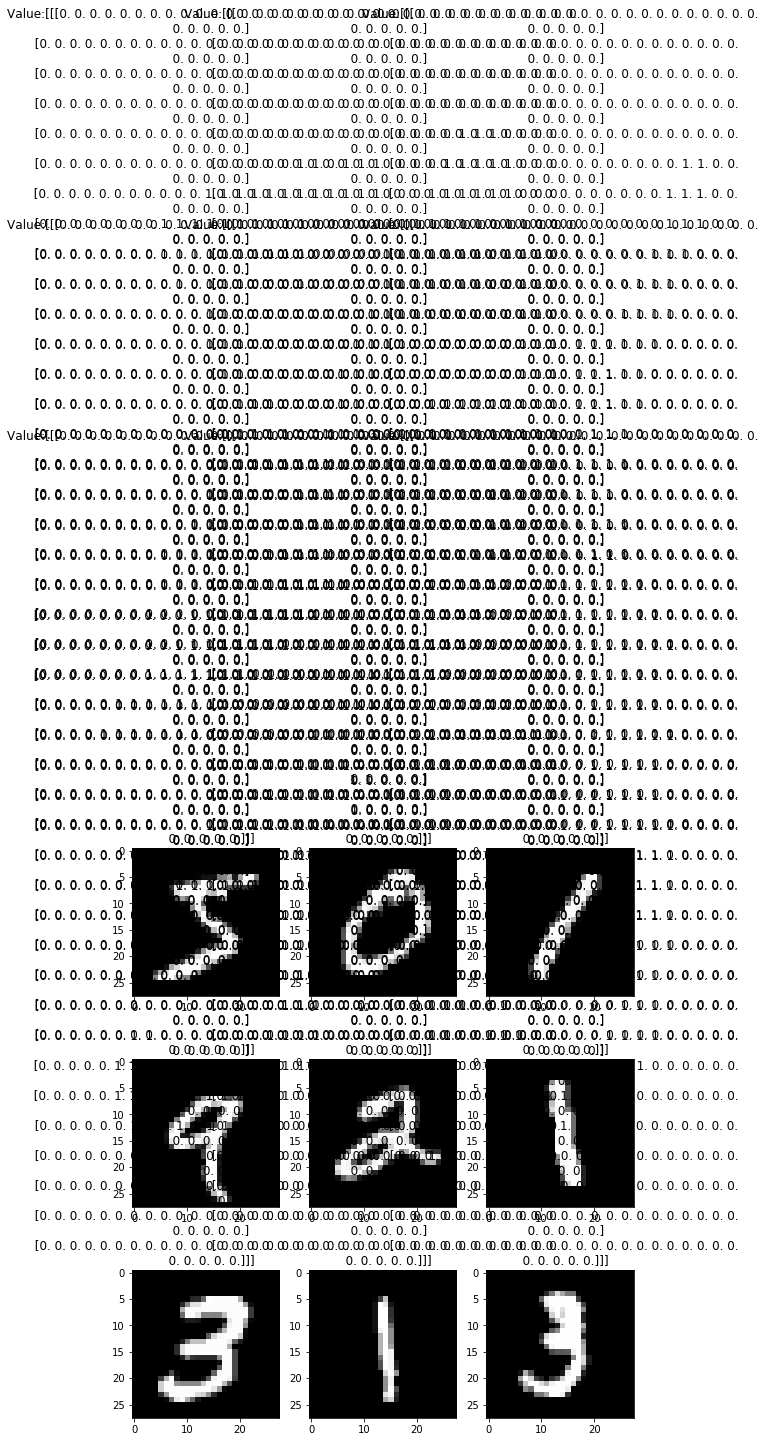

In [20]:
display(rows=3, columns=3, images=train_cut, values=labels_train_cut, predictions=[])

In [21]:
# this code samples quarters with replacement; superceded by the code below that just permutes
train_frankenstein = np.empty((len(train),1,28,28))
for i in range(len(train)):
    idxs = []    
    for j in range(4):
        r = np.random.randint(0,high=len(train))
        idxs.append(r)
    frankenstein = np.zeros((28,28))
    frankenstein[0:14,0:14] = train[idxs[0]][0,0:14,0:14]
    frankenstein[14:,0:14] = train[idxs[1]][0,14:,0:14]
    frankenstein[0:14,14:] = train[idxs[2]][0,0:14,14:]
    frankenstein[14:,14:] = train[idxs[3]][0,14:,14:]
    train_frankenstein[i] = frankenstein
train_frankenstein.shape

(60000, 1, 28, 28)

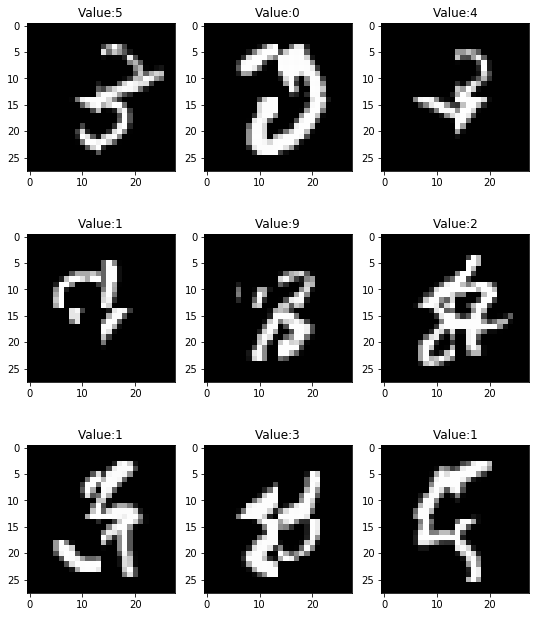

In [22]:
display(rows=3, columns=3, images=train_frankenstein, values=train_csv.iloc[:,0], predictions=[])

In [23]:
test_quarters = test.flatten()
labels_test_quarters = labels_test.flatten()
#split into quarters
#train_quarters = train_quarters.reshape(train.shape[0]*4,1,14,14)
#labels_train_quarters = labels_train_quarters.reshape(train.shape[0]*4,1,14,14)
#split into halves
test_quarters = test_quarters.reshape(test.shape[0]*2,1,14,28)
labels_test_quarters = labels_test_quarters.reshape(test.shape[0]*2,1,14,28)
p = np.random.permutation(test_quarters.shape[0])
test_frankenstein = test_quarters[p]
labels_test_frankenstein = labels_test_quarters[p]
test_frankenstein = test_frankenstein.reshape(test.shape[0],1,28,28)
labels_test_frankenstein = labels_test_frankenstein.reshape(test.shape[0],1,28,28)
#values_frankenstein = train_csv.iloc[:,0][p]
np.save('../data/np/test/images_frankenstein.npy', test_frankenstein)
np.save('../data/np/test/labels_frankenstein.npy', labels_test_frankenstein)

/home/paw/software/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


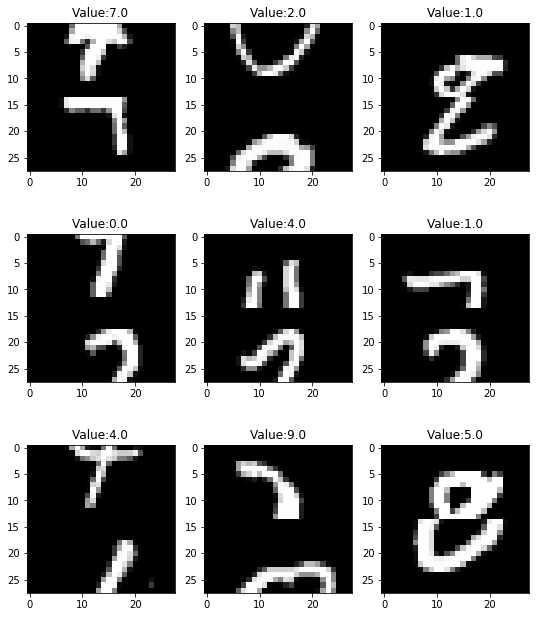

In [24]:
display(rows=3, columns=3, images=test_frankenstein, values=test_csv.iloc[:,0], predictions=[])

In [ ]:
np.array(train_blur[0]).shape
train_blur[0] = np.array(train_blur).reshape(-1, 1, 28, 28)
train_blur[0].shape
#display(rows=r, columns=c, images=np.array(train_blur[0]), values=train_csv.iloc[:,0], predictions=[])

In [ ]:
display(train_blur)

In [ ]:
def plot(imgs, orig_img, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    #plt.tight_layout()

In [ ]:
plot(train_blur, train_pil)